In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import dask.dataframe as dd

### Concat using time_id

In [2]:
files = glob.glob(os.path.join("./individual_book_train", "*.csv"))

def concat_stocks(files, time_id = 5):
    
    # CREATE NEW DATAFRAME - with columns: stock_id and average wap for time_id
    stocks = pd.DataFrame({"stock_id":[], "wap":[], "seconds": []})
    
    for f in files[:]: 

        # LAZY READ TO OPTIMIZE READ TIME
        df = dd.read_csv(f)

        # FIND ONLY COLUMNS WITH time_id ONLY
        df = df[df['time_id'] == time_id]
        df = df.compute()
        
        # COMPUTE WAP COLUMN
        df["wap"] = (df["bid_price1"] * df["ask_size1"] + df["ask_price1"] * df["bid_size1"]) \
                    / (df["bid_size1"] + df["ask_size1"])
        
        d = pd.DataFrame({"stock_id": df["stock_id"], "wap": df["wap"], "seconds": df["seconds_in_bucket"]})
        
        ## FILLING ALL SECONDS WITH STATS FROM SECOND BEFORE (NO MISSING SECONDS)
        i = 0
        while i < 600: 
            if i == len(d) and i < 600 or d.loc[i].seconds > i:
                new = pd.DataFrame({'stock_id':[d.loc[i-1].stock_id], 'wap':[d.loc[i-1].wap], 'seconds':[i]})
                d = pd.concat([d, new]).sort_values('seconds')
                d = d.reset_index(drop=True)
        
            i += 1
    
        stocks = pd.concat([stocks, d]).astype({'stock_id':'int', 'seconds':'int'})
                
    return stocks

### Creating dataframe (may take some time)
- All stocks concatenated by time id

In [3]:
s = concat_stocks(files, time_id = 5)

s

,stock_id,wap,seconds
0,0,1.001434,0
1,0,1.001448,1
2,0,1.001448,2
3,0,1.001448,3
4,0,1.001448,4
...,...,...,...
595,99,1.004193,595
596,99,1.004193,596
597,99,1.004092,597
598,99,1.004211,598


## Computing Beta

In [4]:
def compute_beta(d):
    """
    Computes Beta coeff as Covariance(Stock,Market)/Variance(Market)
    Details found here: https://corporatefinanceinstitute.com/resources/data-science/beta-coefficient/
    """
    c = (((d['wap'] - d['wap_mean']) * (d['market_mean_seconds'] - d['market_mean'])) / len(d)).sum()
    #v = (((d['market_mean_seconds'] - d['market_mean']) ** 2) / len(d)).sum()
    d['beta'] = c/np.var(d['market_mean_seconds'])
    
    return d

In [5]:
# Calculate average wap for stock
s['wap_mean'] = s.groupby(['stock_id'])['wap'].transform('mean')

# Calculate market mean for each second
s['market_mean_seconds'] = s.groupby(['seconds'])['wap'].transform('mean')

# Calculate overall market mean 
s['market_mean'] = s['wap'].mean()

# compute beta for each stock_id
s = s.groupby(['stock_id']).apply(compute_beta)

In [6]:
s

,stock_id,wap,seconds,wap_mean,market_mean_seconds,market_mean,beta
0,0,1.001434,0,1.003690,1.001063,1.002292,1.208072
1,0,1.001448,1,1.003690,1.001089,1.002292,1.208072
2,0,1.001448,2,1.003690,1.001072,1.002292,1.208072
3,0,1.001448,3,1.003690,1.001058,1.002292,1.208072
4,0,1.001448,4,1.003690,1.001070,1.002292,1.208072
...,...,...,...,...,...,...,...
595,126,1.002070,595,1.002218,1.001909,1.002292,1.651032
596,126,1.002070,596,1.002218,1.001909,1.002292,1.651032
597,126,1.002070,597,1.002218,1.001883,1.002292,1.651032
598,126,1.002070,598,1.002218,1.001897,1.002292,1.651032


In [7]:
stock_betas = pd.DataFrame({'stock_id':s['stock_id'].unique(), 'beta':s['beta'].unique()})

stock_betas

,stock_id,beta
0,0,1.208072
1,1,2.201069
2,2,0.267023
3,3,-0.110631
4,4,0.793787
...,...,...
107,122,1.940053
108,123,0.617386
109,124,0.034549
110,125,1.301675


### MeanShift (num clusters decided by data)

In [8]:
from sklearn.cluster import MeanShift, estimate_bandwidth

sb = stock_betas
X = np.reshape(sb['beta'].values, (-1,1))
X

array([[ 1.20807227e+00],
       [ 2.20106938e+00],
       [ 2.67023000e-01],
       [-1.10630930e-01],
       [ 7.93787360e-01],
       [ 2.15473592e+00],
       [ 2.56725563e+00],
       [ 1.54282560e-01],
       [ 3.86013262e+00],
       [-2.64286206e+00],
       [-1.50909942e+00],
       [ 4.98281851e-01],
       [ 8.27157171e-01],
       [ 6.33363539e-02],
       [ 2.17654586e+00],
       [-7.39055849e-01],
       [ 1.61357858e-01],
       [ 1.24144946e-01],
       [ 1.27839271e+00],
       [ 1.12593968e+00],
       [-3.17139276e-01],
       [ 3.21911703e+00],
       [ 5.22104824e-01],
       [ 1.42452001e+00],
       [ 4.45515836e+00],
       [ 8.66364959e-01],
       [ 1.41067671e+00],
       [ 2.45593818e+00],
       [-1.59591730e+00],
       [-4.18400071e-03],
       [ 1.41914099e+00],
       [ 3.68873696e-01],
       [ 3.13853200e-01],
       [-9.40892930e-01],
       [-4.50872442e-01],
       [ 1.60450268e+00],
       [ 6.93076745e-01],
       [-6.09699329e-01],
       [ 1.5

In [9]:
ms = MeanShift(bandwidth=None, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)
print(labels)

number of estimated clusters : 3
[0 0 0 0 0 0 1 0 1 2 2 0 0 0 0 2 0 0 0 0 0 1 0 0 1 0 0 1 2 0 0 0 0 2 2 0 0
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 1
 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0
 0]


### K-means (num clusters will need be decided) - atm using Elbow

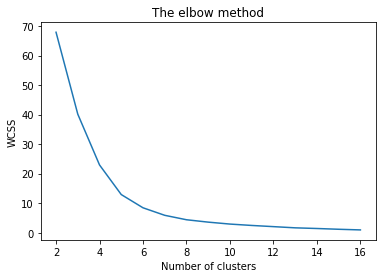

In [10]:
from sklearn.cluster import KMeans

wcss = []

sb = stock_betas
X = np.reshape(sb['beta'].values, (-1,1))
X

for i in range(2, 17):
    kmeans = KMeans(n_clusters = i, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(2, 17), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

In [11]:
km = KMeans(6)

clusts = km.fit_predict(X)
clusts

array([4, 3, 0, 2, 0, 3, 3, 2, 1, 5, 5, 0, 0, 2, 3, 2, 2, 2, 4, 4, 2, 1,
       0, 4, 1, 0, 4, 3, 5, 2, 4, 0, 0, 2, 2, 4, 0, 2, 4, 0, 0, 4, 0, 4,
       3, 4, 2, 0, 2, 4, 4, 2, 2, 3, 3, 4, 3, 0, 3, 2, 0, 4, 0, 0, 4, 4,
       4, 2, 4, 5, 5, 4, 2, 3, 0, 0, 0, 3, 4, 4, 3, 3, 4, 3, 3, 2, 0, 4,
       4, 3, 3, 0, 4, 2, 0, 0, 4, 2, 0, 0, 4, 4, 1, 1, 4, 2, 0, 3, 0, 2,
       4, 4])

## Assigning Cluster IDs

In [12]:
stock_betas['cluster_id'] = clusts
stock_betas

,stock_id,beta,cluster_id
0,0,1.208072,4
1,1,2.201069,3
2,2,0.267023,0
3,3,-0.110631,2
4,4,0.793787,0
...,...,...,...
107,122,1.940053,3
108,123,0.617386,0
109,124,0.034549,2
110,125,1.301675,4


### Analysing clusters

<AxesSubplot:title={'center':'beta'}, xlabel='cluster_id'>

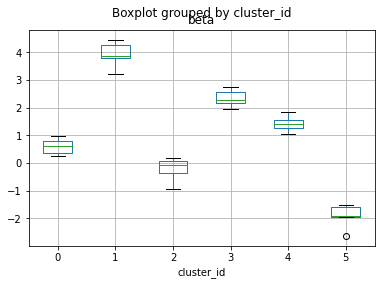

In [13]:
stock_betas.boxplot(column = 'beta', by='cluster_id')

In [14]:
stock_betas.groupby(['cluster_id'])['beta'].median()

cluster_id
0    0.595740
1    3.860133
2   -0.060729
3    2.284905
4    1.421830
5   -1.903585
Name: beta, dtype: float64

In [15]:
stock_betas.groupby(['cluster_id'])['beta'].min()

cluster_id
0    0.246674
1    3.219117
2   -0.940893
3    1.940053
4    1.035428
5   -2.642862
Name: beta, dtype: float64

In [16]:
stock_betas.groupby(['cluster_id'])['beta'].max()

cluster_id
0    0.987877
1    4.455158
2    0.191747
3    2.735891
4    1.831418
5   -1.509099
Name: beta, dtype: float64

Maybe can use beta ranges for to decide CAPM model based off cluster_id

### Extra: Code found online for comparing cluster quality with selected K

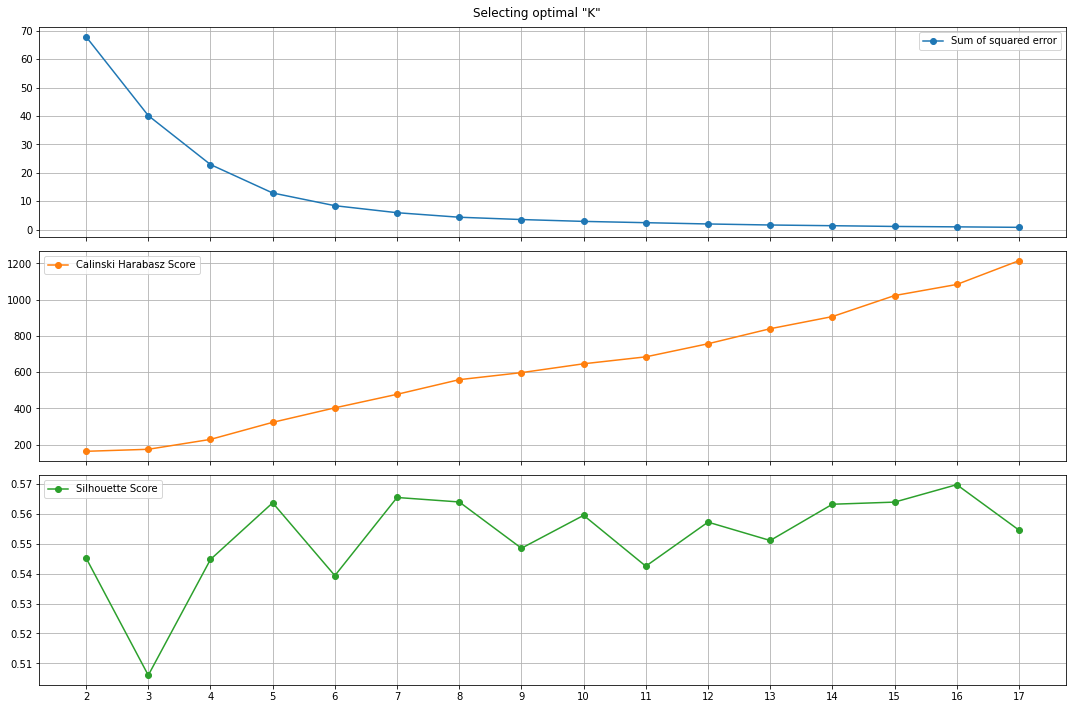

In [17]:
from sklearn.cluster import KMeans
from sklearn import metrics

X_segmentation = X

search_range = range(2, 18)
report = {}
for k in search_range:
    temp_dict = {}
    kmeans = KMeans(k)
    #inertia = kmeans.inertia_
    #temp_dict['Sum of squared error'] = inertia
    
    cluster = kmeans.fit_predict(X_segmentation)
    
    inertia = kmeans.inertia_
    temp_dict['Sum of squared error'] = inertia
    chs = metrics.calinski_harabasz_score(X_segmentation, cluster)
    ss = metrics.silhouette_score(X_segmentation, cluster)
    temp_dict['Calinski Harabasz Score'] = chs
    temp_dict['Silhouette Score'] = ss
    report[k] = temp_dict
    

report_df = pd.DataFrame(report).T
report_df.plot(figsize=(15, 10),
               xticks=search_range,
               grid=True,
               title=f'Selecting optimal "K"',
               subplots=True,
               marker='o',
               sharex=True)
plt.tight_layout()

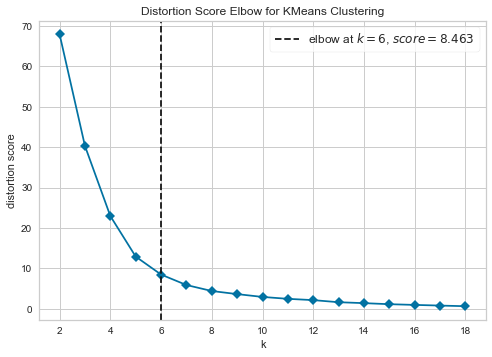

KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=18, random_state=1), k=(2, 19),
                 timings=False)

In [18]:
#!pip install yellowbrick
from yellowbrick.cluster.elbow import kelbow_visualizer

kelbow_visualizer(KMeans(random_state=1),
                  X_segmentation,
                  k=(2, 19),
                  timings=False)